In [1]:
import pandas as pd
import numpy as pandas
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import wordnet
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec,TaggedDocument
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,precision_score,recall_score
from sklearn.metrics import classification_report
import pickle

F:\anaconda\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


# Load Data

In [2]:
data=pd.read_csv("Downloads\\Hotel_Reviews.csv")
data.head()

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,08-03-2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,08-03-2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3 days,52.360576,4.915968
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/24/2017,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8,3,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10 days,52.360576,4.915968


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Hotel_Address                               515738 non-null  object 
 1   Additional_Number_of_Scoring                515738 non-null  int64  
 2   Review_Date                                 515738 non-null  object 
 3   Average_Score                               515738 non-null  float64
 4   Hotel_Name                                  515738 non-null  object 
 5   Reviewer_Nationality                        515738 non-null  object 
 6   Negative_Review                             515738 non-null  object 
 7   Review_Total_Negative_Word_Counts           515738 non-null  int64  
 8   Total_Number_of_Reviews                     515738 non-null  int64  
 9   Positive_Review                             515738 non-null  object 
 

In [4]:
data['review']=data['Negative_Review']+data['Positive_Review']
data['bad_review']=data['Reviewer_Score'].apply(lambda x: 1 if x<5 else 0)
data_review=data[['review','bad_review']]
data_review

,review,bad_review
0,I am so angry that i made this post available...,1
1,No Negative No real complaints the hotel was g...,0
2,Rooms are nice but for elderly a bit difficul...,0
3,My room was dirty and I was afraid to walk ba...,1
4,You When I booked with your company on line y...,0
...,...,...
515733,no trolly or staff to help you take the lugga...,0
515734,The hotel looks like 3 but surely not 4 Brea...,0
515735,The ac was useless It was a hot week in vienn...,1
515736,No Negative The rooms are enormous and really ...,0


In [5]:
data_review['review'][0]

' I am so angry that i made this post available via all possible sites i use when planing my trips so no one will make the mistake of booking this place I made my booking via booking com We stayed for 6 nights in this hotel from 11 to 17 July Upon arrival we were placed in a small room on the 2nd floor of the hotel It turned out that this was not the room we booked I had specially reserved the 2 level duplex room so that we would have a big windows and high ceilings The room itself was ok if you don t mind the broken window that can not be closed hello rain and a mini fridge that contained some sort of a bio weapon at least i guessed so by the smell of it I intimately asked to change the room and after explaining 2 times that i booked a duplex btw it costs the same as a simple double but got way more volume due to the high ceiling was offered a room but only the next day SO i had to check out the next day before 11 o clock in order to get the room i waned to Not the best way to begin y

# Sample Data

In [6]:
data_review=data_review.sample(frac=0.1,replace=False,random_state=42)

Reviews data is sampled in order to speed up computations.

In [7]:
data_review

,review,bad_review
488440,Would have appreciated a shop in the hotel th...,0
274649,No tissue paper box was present at the roomNo...,0
374688,Pillows Nice welcoming and service,0
404352,No Negative Everything including the nice upgr...,0
451596,No Negative Lovely hotel v welcoming staff,0
...,...,...
274862,Bathroom water easy made the bathroom wet whe...,0
9732,Room very small chair tatty in the room No Po...,1
424201,Expensive rates and mini bar prices Roof top ...,0
72380,There was a very loud AC machine right outsid...,0


# Clean Data

In [8]:
data_review['review']=data_review['review'].apply(lambda x: x.replace("No Negative","").replace("No Positive",""))
data_review

,review,bad_review
488440,Would have appreciated a shop in the hotel th...,0
274649,No tissue paper box was present at the room,0
374688,Pillows Nice welcoming and service,0
404352,Everything including the nice upgrade The Hot...,0
451596,Lovely hotel v welcoming staff,0
...,...,...
274862,Bathroom water easy made the bathroom wet whe...,0
9732,Room very small chair tatty in the room,1
424201,Expensive rates and mini bar prices Roof top ...,0
72380,There was a very loud AC machine right outsid...,0


If the user doesn't leave any negative feedback comment, this will appear as "No Negative" in our data. This is the same for the positive comments with the default value "No Positive". We have to remove those parts from our texts.

In [9]:
def get_wordnet(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def clean_text(text):
    #lower text
    text=text.lower()
    #tokenize text and remove puncutation
    text=[word.strip(string.punctuation) for word in text.split(' ')]
    #remove words that contain numbers
    text=[word for word in text if not any(c.isdigit() for c in word)]
    #remove stopwords
    stop=stopwords.words("english")
    text=[x for x in text if x not in stop]
    #remove empty tokens
    text=[t for t in text if len(t)>0]
    #pos-tag text
    pos_tags=pos_tag(text)
    #lemmatize text
    text=[WordNetLemmatizer().lemmatize(t[0],get_wordnet(t[1])) for t in pos_tags]
    #remove words with only one letter
    text=[t for t in text if len(t)>1]
    #join all
    text=" ".join(text)
    return text

#clean text data
data_review['review_clean']=data_review['review'].apply(lambda x: clean_text(x))      

# To clean textual data, we call our custom 'clean_text' function that performs several transformations:

1.lower the text<br>
2.tokenize the text (split the text into words) and remove the punctuation<br>
3.remove useless words that contain numbers<br>
4.remove useless stop words like 'the', 'a' ,'this' etc.<br>
5.Part-Of-Speech (POS) tagging: assign a tag to every word to define if it corresponds to a noun, a verb etc. using the WordNet lexical database<br>
6.lemmatize the text: transform every word into their root form (e.g. rooms -> room, slept -> sleep)
Now that we have cleaned our data, we can do some feature engineering for our modelization part.<br>

In [10]:
data_review

,review,bad_review,review_clean
488440,Would have appreciated a shop in the hotel th...,0,would appreciate shop hotel sell drinking wate...
274649,No tissue paper box was present at the room,0,tissue paper box present room
374688,Pillows Nice welcoming and service,0,pillow nice welcome service
404352,Everything including the nice upgrade The Hot...,0,everything include nice upgrade hotel revamp s...
451596,Lovely hotel v welcoming staff,0,lovely hotel welcome staff
...,...,...,...
274862,Bathroom water easy made the bathroom wet whe...,0,bathroom water easy make bathroom wet bath wal...
9732,Room very small chair tatty in the room,1,room small chair tatty room
424201,Expensive rates and mini bar prices Roof top ...,0,expensive rate mini bar price roof top pool vi...
72380,There was a very loud AC machine right outsid...,0,loud ac machine right outside window affect sl...


# Feature Engineering

In [11]:
sid=SentimentIntensityAnalyzer()
data_review["sentiments"]=data_review['review'].apply(lambda x: sid.polarity_scores(x))
data_review = pd.concat([data_review.drop(['sentiments'],axis=1),data_review['sentiments'].apply(pd.Series)],axis=1)

We first start by adding sentiment analysis features because we can guess that customers reviews are highly linked to how they felt about their stay at the hotel. We use Vader, which is a part of the NLTK module designed for sentiment analysis. Vader uses a lexicon of words to find which ones are positives or negatives. It also takes into accout the context of the sentences to determine the sentiment scores. For each text, Vader retuns 4 values:
<br>
1. a neutrality score<br>
2. a positivity score<br>
3. a negativity score<br>
4.compound an overall score that summarizes the previous scores<br>

We will integrate those 4 values as features in our dataset.

In [12]:
data_review

,review,bad_review,review_clean,neg,neu,pos,compound
488440,Would have appreciated a shop in the hotel th...,0,would appreciate shop hotel sell drinking wate...,0.049,0.617,0.334,0.9924
274649,No tissue paper box was present at the room,0,tissue paper box present room,0.216,0.784,0.000,-0.2960
374688,Pillows Nice welcoming and service,0,pillow nice welcome service,0.000,0.345,0.655,0.6908
404352,Everything including the nice upgrade The Hot...,0,everything include nice upgrade hotel revamp s...,0.000,0.621,0.379,0.9153
451596,Lovely hotel v welcoming staff,0,lovely hotel welcome staff,0.000,0.230,0.770,0.7717
...,...,...,...,...,...,...,...
274862,Bathroom water easy made the bathroom wet whe...,0,bathroom water easy make bathroom wet bath wal...,0.000,0.614,0.386,0.8834
9732,Room very small chair tatty in the room,1,room small chair tatty room,0.000,1.000,0.000,0.0000
424201,Expensive rates and mini bar prices Roof top ...,0,expensive rate mini bar price roof top pool vi...,0.000,0.886,0.114,0.2023
72380,There was a very loud AC machine right outsid...,0,loud ac machine right outside window affect sl...,0.047,0.845,0.108,0.4767


In [13]:
#number of characters in each review
data_review['nb_chars']=data_review['review'].apply(lambda x: len(x))
#number of words in each review
data_review['nb_words']=data_review['review'].apply(lambda x: len(x.split(" ")))

Next, we add some simple metrics for every text:

1. number of characters in the text
2. number of words in the text

In [14]:
data_review

,review,bad_review,review_clean,neg,neu,pos,compound,nb_chars,nb_words
488440,Would have appreciated a shop in the hotel th...,0,would appreciate shop hotel sell drinking wate...,0.049,0.617,0.334,0.9924,599,113
274649,No tissue paper box was present at the room,0,tissue paper box present room,0.216,0.784,0.000,-0.2960,44,10
374688,Pillows Nice welcoming and service,0,pillow nice welcome service,0.000,0.345,0.655,0.6908,36,7
404352,Everything including the nice upgrade The Hot...,0,everything include nice upgrade hotel revamp s...,0.000,0.621,0.379,0.9153,155,27
451596,Lovely hotel v welcoming staff,0,lovely hotel welcome staff,0.000,0.230,0.770,0.7717,32,7
...,...,...,...,...,...,...,...,...,...
274862,Bathroom water easy made the bathroom wet whe...,0,bathroom water easy make bathroom wet bath wal...,0.000,0.614,0.386,0.8834,142,25
9732,Room very small chair tatty in the room,1,room small chair tatty room,0.000,1.000,0.000,0.0000,41,10
424201,Expensive rates and mini bar prices Roof top ...,0,expensive rate mini bar price roof top pool vi...,0.000,0.886,0.114,0.2023,80,16
72380,There was a very loud AC machine right outsid...,0,loud ac machine right outside window affect sl...,0.047,0.845,0.108,0.4767,176,36


In [15]:
# create doc2vec vector columns
documents=[TaggedDocument(doc,[i]) for i ,doc in enumerate(data_review['review_clean'].apply(lambda x: x.split(" ")))] #same as word tokenize
# train a Doc2Vec model with our text data
model=Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)
# transform each document into a vector data
data_doc2vec=data_review['review_clean'].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
data_doc2vec.columns=["doc2vec_vector_"+str(x) for x in data_doc2vec.columns]
data_review=pd.concat([data_review,data_doc2vec],axis=1)

Doc2vec is an NLP tool for representing documents as a vector and is a generalizing of the word2vec method
The module Gensim creates a numerical vector representation of every word in the corpus by using the contexts in which they appear (Word2Vec). This is performed using shallow neural networks. What's interesting is that similar words will have similar representation vectors.

Each text can also be transformed into numerical vectors using the word vectors (Doc2Vec). Same texts will also have similar representations and that is why we can use those vectors as training features.

We first have to train a Doc2Vec model by feeding in our text data. By applying this model on our reviews, we can get those representation vectors.

In [16]:
data_review

,review,bad_review,review_clean,neg,neu,pos,compound,nb_chars,nb_words,doc2vec_vector_0,doc2vec_vector_1,doc2vec_vector_2,doc2vec_vector_3,doc2vec_vector_4
488440,Would have appreciated a shop in the hotel th...,0,would appreciate shop hotel sell drinking wate...,0.049,0.617,0.334,0.9924,599,113,-0.113763,0.327827,-0.191065,-0.050622,-0.541701
274649,No tissue paper box was present at the room,0,tissue paper box present room,0.216,0.784,0.000,-0.2960,44,10,0.033815,-0.038924,0.112862,0.071426,-0.096842
374688,Pillows Nice welcoming and service,0,pillow nice welcome service,0.000,0.345,0.655,0.6908,36,7,-0.041348,0.162231,0.096871,-0.044005,0.025801
404352,Everything including the nice upgrade The Hot...,0,everything include nice upgrade hotel revamp s...,0.000,0.621,0.379,0.9153,155,27,-0.024629,0.288479,0.198933,-0.014945,0.043688
451596,Lovely hotel v welcoming staff,0,lovely hotel welcome staff,0.000,0.230,0.770,0.7717,32,7,0.010722,0.102534,0.073447,-0.049271,-0.111069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274862,Bathroom water easy made the bathroom wet whe...,0,bathroom water easy make bathroom wet bath wal...,0.000,0.614,0.386,0.8834,142,25,-0.187887,-0.148204,0.321205,0.338350,-0.148428
9732,Room very small chair tatty in the room,1,room small chair tatty room,0.000,1.000,0.000,0.0000,41,10,0.183942,0.014980,0.111419,0.000641,-0.130107
424201,Expensive rates and mini bar prices Roof top ...,0,expensive rate mini bar price roof top pool vi...,0.000,0.886,0.114,0.2023,80,16,0.014963,0.256254,0.089279,-0.087845,0.033170
72380,There was a very loud AC machine right outsid...,0,loud ac machine right outside window affect sl...,0.047,0.845,0.108,0.4767,176,36,0.155461,-0.145840,-0.049262,0.028278,-0.310179


In [17]:
tfidf=TfidfVectorizer(min_df=10)
tfidf_result=tfidf.fit_transform(data_review['review_clean']).toarray()
data_tfidf=pd.DataFrame(tfidf_result,columns=tfidf.get_feature_names())
data_tfidf.columns=["word_"+ str(x) for x in data_tfidf.columns]
data_tfidf.index=data_review.index
data_review=pd.concat([data_review,data_tfidf],axis=1)

Finally we add the TF-IDF (Term Frequency - Inverse Document Frequency) values for every word and every document.<br>
<br>
But why not simply counting how many times each word appears in every document? The problem with this method is that it doesn't take into account the relative importance of words in the texts. A word that appears in almost every text would not likely bring useful information for analysis. On the contrary, rare words may have a lot more of meanings.

The TF-IDF metric solves this problem:

1. TF computes the classic number of times the word appears in the text<br>
2. IDF computes the relative importance of this word which depends on how many texts the word can be found<br>
We add TF-IDF columns for every word that appear in at least 10 different texts to filter some of them and reduce the size of the final output.

In [18]:
data_review

,review,bad_review,review_clean,neg,neu,pos,compound,nb_chars,nb_words,doc2vec_vector_0,...,word_yet,word_yoghurt,word_yogurt,word_young,word_yr,word_yummy,word_zero,word_ziggo,word_zone,word_zuid
488440,Would have appreciated a shop in the hotel th...,0,would appreciate shop hotel sell drinking wate...,0.049,0.617,0.334,0.9924,599,113,-0.113763,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
274649,No tissue paper box was present at the room,0,tissue paper box present room,0.216,0.784,0.000,-0.2960,44,10,0.033815,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
374688,Pillows Nice welcoming and service,0,pillow nice welcome service,0.000,0.345,0.655,0.6908,36,7,-0.041348,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
404352,Everything including the nice upgrade The Hot...,0,everything include nice upgrade hotel revamp s...,0.000,0.621,0.379,0.9153,155,27,-0.024629,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
451596,Lovely hotel v welcoming staff,0,lovely hotel welcome staff,0.000,0.230,0.770,0.7717,32,7,0.010722,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274862,Bathroom water easy made the bathroom wet whe...,0,bathroom water easy make bathroom wet bath wal...,0.000,0.614,0.386,0.8834,142,25,-0.187887,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9732,Room very small chair tatty in the room,1,room small chair tatty room,0.000,1.000,0.000,0.0000,41,10,0.183942,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
424201,Expensive rates and mini bar prices Roof top ...,0,expensive rate mini bar price roof top pool vi...,0.000,0.886,0.114,0.2023,80,16,0.014963,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
72380,There was a very loud AC machine right outsid...,0,loud ac machine right outside window affect sl...,0.047,0.845,0.108,0.4767,176,36,0.155461,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Exploratory Data Analysis

In order to have a better understanding of our data, let's explore it a little:

In [19]:
data_review.shape

(51574, 3840)

In [20]:
data_review['bad_review'].value_counts(normalize=True)

0    0.956761
1    0.043239
Name: bad_review, dtype: float64

Our dataset is highly imbalanced because less than 5% of our reviews are considered as negative ones. This information will be very useful for the modelling part.

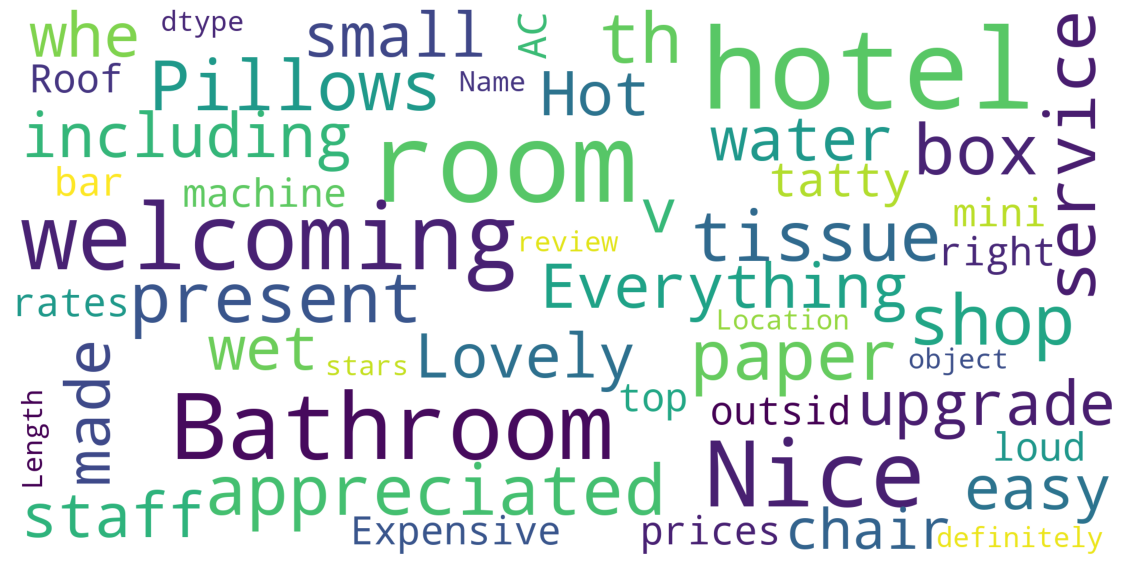

In [21]:
def show_wordcloud(data,title=None):
    wordcloud=WordCloud(background_color='white',max_words=200,max_font_size=40,scale=5,random_state=42).generate(str(data))
    fig=plt.figure(1,figsize=(20,20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)
    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(data_review["review"])


Word Cloud is a data visualization technique used for representing text data in which the size of each word indicates its frequency or importance. Significant textual data points can be highlighted using a word cloud. Word clouds are widely used for analyzing data from social network websites.

In [22]:
# highest positive sentiment reviews (with more than 5 words)
data_review[data_review["nb_words"] >= 5].sort_values("pos", ascending = False)[["review", "pos"]].head(10)

,review,pos
43101,A perfect location comfortable great value,0.931
211742,Clean comfortable lovely staff,0.907
175551,Friendly welcome Comfortable room,0.905
365085,Good location great value,0.904
109564,Clean friendly and comfortable,0.902
145743,Good value amazing location,0.901
407590,breakfast excellent Clean comfort,0.899
407546,Great place I enjoyed,0.881
218571,Beautiful Quirky Comfortable,0.878
128308,Super friendly staff,0.877


In [23]:
# lowest negative sentiment reviews (with more than 5 words)
data_review[data_review["nb_words"] >= 5].sort_values("neg", ascending = False)[["review", "neg"]].head(10)

,review,neg
193086,No dislikes LOCATION,0.831
356368,Nothing Great helpful wonderful staff,0.812
318516,A disaster Nothing,0.804
458794,Nothing Excellent friendly helpful staff,0.799
29666,A bit noisy No,0.796
426057,Dirty hotel Smells bad,0.762
263187,Very bad service No,0.758
443796,Nothing perfect,0.750
181508,Window blind was broken,0.744
175316,Nothing Super friendly staff,0.743


F:\anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
F:\anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


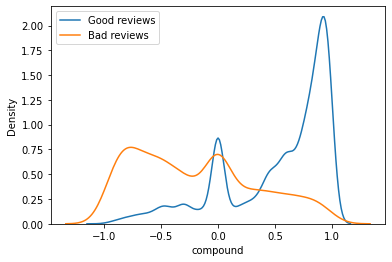

In [24]:
# plot sentiment distribution for positive and negative reviews
for x in [0, 1]:
    subset = data_review[data_review['bad_review'] == x]
    
    # Draw the density plot
    if x == 0:
        label = "Good reviews"
    else:
        label = "Bad reviews"
    sns.distplot(subset['compound'], hist = False, label = label)
plt.legend()
plt.show()

The above graph shows the distribution of the reviews sentiments among good reviews and bad ones. We can see that good reviews are for most of them considered as very positive. On the contrary, bad reviews tend to have lower compound sentiment scores.

This shows us that previously computed sentiment features will be very important in our modelling part.

# Modeling reviewier score

In [25]:
#feature selection
label=['bad_review']
ignore_cols=['label','review','review_clean']
features=[x for x in data_review.columns if x not in ignore_cols]
X=data_review[features]
y=data_review[label]

In [26]:
y.value_counts()

bad_review
0             49344
1              2230
dtype: int64

# Balancing Data using SMOTE

In [27]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(sampling_strategy='minority',random_state=42)
X_smote,y_smote=smote.fit_resample(X,y)     

MemoryError: Unable to allocate 1.35 GiB for an array with shape (47114, 3838) and data type float64

SMOTE (Synthetic Minority Oversampling Technique) – Oversampling
SMOTE (synthetic minority oversampling technique) is one of the most commonly used oversampling methods to solve the imbalance problem.
It aims to balance class distribution by randomly increasing minority class examples by replicating them.

We first choose which features we want to use to train our model. Then we split our data into two parts:

1. one to train our model
2. one to assess its performances<br>


We will next use a Random Forest (RF) classifier for our predictions.

In [ ]:
y_smote.value_counts()

In [28]:
#split data in to train and test
X_train,X_test,y_train,y_test=train_test_split(X_smote,y_smote,test_size=0.2,random_state=42)

In [30]:
#train a random forest classifier
model_rf=RandomForestClassifier(n_estimators=100,random_state=42)
model=model_rf.fit(X_train,y_train)

MemoryError: Unable to allocate 1.18 GiB for an array with shape (3838, 41259) and data type float64

In [ ]:
pred=model_rf.predict(X_test)
print(confusion_matrix(pred,y_test))
print(accuracy_score(pred,y_test))
print(precision_score(pred,y_test))
print(recall_score(pred,y_test))

In [ ]:
print(classification_report(y_test,pred))

# Dumping model into pickle

In [ ]:
with open('sentiment_analysis_on_hotel_reviews_pickle_file','wb') as f:
    pickle.dump(model,f)

In [ ]:
with open('sentiment_analysis_on_hotel_reviews_pickle_file','rb') as f:
    model_pickle=pickle.load(f)
    
sentence=' I am so angry that i made this post available via all possible sites i use when planing my trips so no one will make the mistake of booking this place I made my booking via booking com We stayed for 6 nights in this hotel from 11 to 17 July Upon arrival we were placed in a small room on the 2nd floor of the hotel It turned out that this was not the room we booked I had specially reserved the 2 level duplex room so that we would have a big windows and high ceilings The room itself was ok if you don t mind the broken window that can not be closed hello rain and a mini fridge that contained some sort of a bio weapon at least i guessed so by the smell of it I intimately asked to change the room and after explaining 2 times that i booked a duplex btw it costs the same as a simple double but got way more volume due to the high ceiling was offered a room but only the next day SO i had to check out the next day before 11 o clock in order to get the room i waned to Not the best way to begin your holiday So we had to wait till 13 00 in order to check in my new room what a wonderful waist of my time The room 023 i got was just as i wanted to peaceful internal garden view big window We were tired from waiting the room so we placed our belongings and rushed to the city In the evening it turned out that there was a constant noise in the room i guess it was made by vibrating vent tubes or something it was constant and annoying as hell AND it did not stop even at 2 am making it hard to fall asleep for me and my wife I have an audio recording that i can not attach here but if you want i can send it via e mail The next day the technician came but was not able to determine the cause of the disturbing sound so i was offered to change the room once again the hotel was fully booked and they had only 1 room left the one that was smaller but seems newer  Only the park outside of the hotel was beautiful '    
sentence=sentence.replace("No Negative","").replace("No Positive","")
def get_wordnet(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def clean_text(text):
    #lower text
    text=text.lower()
    #tokenize text and remove puncutation
    text=[word.strip(string.punctuation) for word in text.split(' ')]
    #remove words that contain numbers
    text=[word for word in text if not any(c.isdigit() for c in word)]
    #remove stopwords
    stop=stopwords.words("english")
    text=[x for x in text if x not in stop]
    #remove empty tokens
    text=[t for t in text if len(t)>0]
    #pos-tag text
    pos_tags=pos_tag(text)
    #lemmatize text
    text=[WordNetLemmatizer().lemmatize(t[0],get_wordnet(t[1])) for t in pos_tags]
    #remove words with only one letter
    text=[t for t in text if len(t)>1]
    #join all
    text=" ".join(text)
    return text

#clean text data
sentence=clean_text(sentence)

sid=SentimentIntensityAnalyzer()
score=sid.polarity_scores(sentence)
data = pd.DataFrame(score,index=[0])

#number of characters in each review
data['nb_chars']=len(sentence)
#number of words in each review
data['nb_words']=len(sentence.split(" "))

# create doc2vec vector columns
documents=[TaggedDocument(doc,[i]) for i ,doc in enumerate(sentence.split(" "))] #same as word tokenize
# train a Doc2Vec model with our text data
model=Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)
# transform each document into a vector data
data_doc2vec=model.infer_vector(sentence.split(" "))
data["doc2vec_vector_1"]=data_doc2vec[0]
data["doc2vec_vector_2"]=data_doc2vec[1]
data["doc2vec_vector_3"]=data_doc2vec[2]
data["doc2vec_vector_4"]=data_doc2vec[3]
data["doc2vec_vector_5"]=data_doc2vec[4]
data.insert(loc=0, column='review', value=sentence)

tfidf=TfidfVectorizer()
tfidf_result=tfidf.fit_transform(data['review']).toarray()
data_tfidf=pd.DataFrame(tfidf_result,columns=tfidf.get_feature_names())
data_tfidf.columns=["word_"+ str(x) for x in data_tfidf.columns]
data_tfidf.index=data.index
data=pd.concat([data,data_tfidf],axis=1)

data.drop(['review'],axis=1,inplace=True)

output=model_pickle.predict(data)
if output==1:
    string='Negative Review'
elif output==0:
    string='Positive Review'
else:
    string="neutral"
        
print(string)        
